### Import libraries and datasets:

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error

from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.api import VAR

In [ ]:
csv_fts = "datasets/FTS Historical Data.csv"
csv_mwg = "datasets/MWG Historical Data.csv"
csv_vic = "datasets/VIC Historical Data.csv"

df_fts = pd.read_csv(csv_fts, thousands=',')
df_mwg = pd.read_csv(csv_mwg, thousands=',')
df_vic = pd.read_csv(csv_vic, thousands=',')

### Dataset 1: FTS

- Cast Date column to datetime type
- Sort data ascending by Date

In [ ]:
df_fts['Date'] = pd.to_datetime(df_fts['Date'])
df_fts = df_fts.sort_values(by='Date', ascending=True)
df_fts.head(5)

,Date,Price,Open,High,Low,Vol.,Change %
1359,2018-01-02,5788.4,5859.2,5859.2,5788.4,103.55K,-1.21%
1358,2018-01-03,5953.7,5764.7,5977.4,5741.1,245.02K,2.86%
1357,2018-01-04,6024.6,5953.7,6142.8,5906.5,167.80K,1.19%
1356,2018-01-05,5882.9,5977.4,6048.2,5882.9,113.88K,-2.35%
1355,2018-01-08,6001.0,5859.2,6001.0,5764.7,63.36K,2.01%


- Split Price data
- Reset index

In [ ]:
df_price = df_fts[['Price', 'Open']]
df_price = df_price.reset_index(drop=True)
df_price.head(5)

,Price,Open
0,5788.4,5859.2
1,5953.7,5764.7
2,6024.6,5953.7
3,5882.9,5977.4
4,6001.0,5859.2


- Scale data between 0 and 1:

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
df_price['Price'] = scaler.fit_transform(np.array(df_price['Price']).reshape(-1,1))
df_price['Open'] = scaler.transform(np.array(df_price['Open']).reshape(-1,1))
df_price.head(5)

,Price,Open
0,0.000000,0.001536
1,0.003587,-0.000514
2,0.005125,0.003587
3,0.002051,0.004101
4,0.004613,0.001536


- Split data into train, test, val (7 - 2 - 1):

In [ ]:
train_size = int(0.7 * len(df_price))
test_size = int(0.2 * len(df_price))
val_size = len(df_price) - train_size - test_size

train_data = df_price[:train_size]
test_data = df_price[train_size:train_size+test_size]
val_data = df_price[train_size+test_size:]

print(train_data.shape)
print(test_data.shape)
print(val_data.shape)

(951, 2)
(272, 2)
(137, 2)


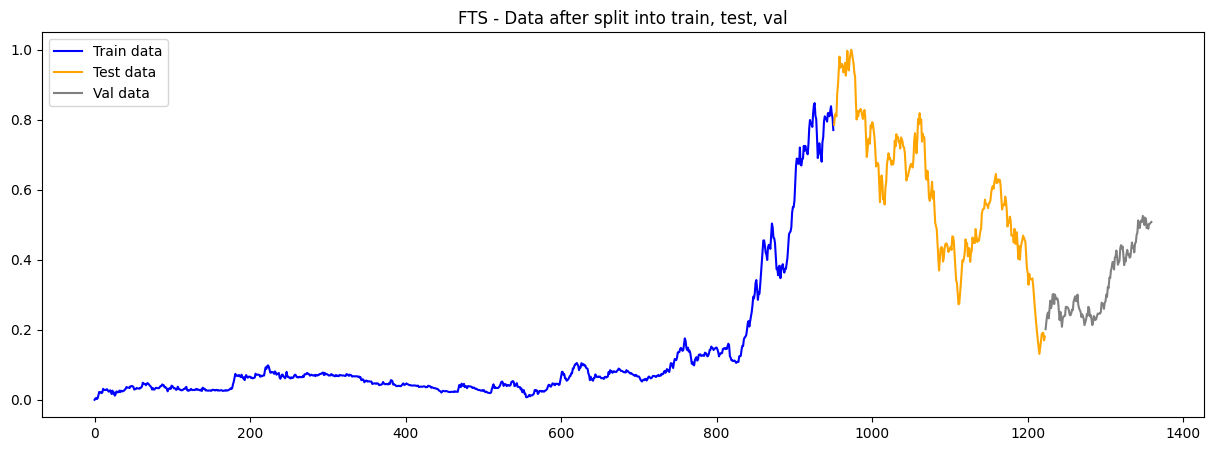

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(train_data.index, train_data['Price'], 'b')
plt.plot(test_data.index, test_data['Price'], 'orange')
plt.plot(val_data.index, val_data['Price'], 'gray')
plt.legend(['Train data', 'Test data', 'Val data'], loc='upper left')
plt.title('FTS - Data after split into train, test, val')
plt.show()

- Model training:

In [ ]:
model_var = VAR(train_data)
for i in [1,2,3,4,5,6,7,8,9,10]:
    results = model_var.fit(i)
    print('Order =', i)
    print('AIC: ', results.aic)
    print('BIC: ', results.bic)
    print()

Order = 1
AIC:  -20.270518289343183
BIC:  -20.23984589786153

Order = 2
AIC:  -20.276169731531173
BIC:  -20.225006308995766

Order = 3
AIC:  -20.291469801585762
BIC:  -20.219781022016598

Order = 4
AIC:  -20.29757379526985
BIC:  -20.2053252380604

Order = 5
AIC:  -20.30725536810125
BIC:  -20.194412517658183

Order = 6
AIC:  -20.315244799041313
BIC:  -20.181773044422435

Order = 7
AIC:  -20.324095958027943
BIC:  -20.169960592578406

Order = 8
AIC:  -20.331717894296347
BIC:  -20.15688411528305

Order = 9
AIC:  -20.346893272983653
BIC:  -20.15132618122792

Order = 10
AIC:  -20.3490533488433
BIC:  -20.13271794835171



In [ ]:
result = model_var.fit(10)
result.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 17, Jun, 2023
Time:                     10:57:19
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -20.1327
Nobs:                     941.000    HQIC:                  -20.2666
Log likelihood:           6945.79    FPE:                1.45387e-09
AIC:                     -20.3491    Det(Omega_mle):     1.39109e-09
--------------------------------------------------------------------
Results for equation Price
               coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------
const             0.000232         0.000348            0.668           0.504
L1.Price          1.277341         0.034639           36.876           0.000
L1.Open          -0.261467         0.068191           -3.834           0.000

- Model Prediction on test, val (one-step prediction):

In [ ]:
lags_order = result.k_ar

In [ ]:
y_pred_test = []
for i in range(test_data.shape[0] - lags_order):
    forecast_input = test_data[i:(i+lags_order)].values
    pred = result.forecast(forecast_input, steps=1)
    y_pred_test.append(list(pred[0]))

y_pred_test = np.array(y_pred_test)[:, 0]

In [ ]:
y_pred_val = []
for i in range(val_data.shape[0] - lags_order):
    forecast_input = val_data[i:(i+lags_order)].values
    pred = result.forecast(forecast_input, steps=1)
    y_pred_val.append(list(pred[0]))

y_pred_val = np.array(y_pred_val)[:, 0]

In [ ]:
y_pred_test = scaler.inverse_transform(y_pred_test.reshape(-1, 1))
y_pred_val = scaler.inverse_transform(y_pred_val.reshape(-1, 1))

- 30 days prediction:

In [ ]:
number_of_days_to_predict = 30

In [ ]:
ndays_pred = result.forecast(df_price[-lags_order-number_of_days_to_predict:-number_of_days_to_predict].values, steps=number_of_days_to_predict)
ndays_pred = np.array(ndays_pred)[:, 0]
ndays_pred = scaler.inverse_transform(np.array(ndays_pred).reshape(-1, 1))

- Model evaluating (RMSE - MAPE - MSLE):

In [ ]:
y_test = test_data['Price'].values[lags_order:]
y_val = val_data['Price'].values[lags_order:]
last_ndays_data = val_data['Price'].values[-number_of_days_to_predict:]

In [ ]:
last_ndays_data = df_price[-number_of_days_to_predict:]['Price'].values

# RMSE
test_rmse = mean_squared_error(y_pred_test, y_test, squared=False)
val_rmse = mean_squared_error(y_pred_val, y_val, squared=False)
ndays_rmse = mean_squared_error(ndays_pred, last_ndays_data, squared=False)
print('Testing RMSE:', np.round(test_rmse, 4))
print('Validating RMSE:', np.round(val_rmse, 4))
print('Predicting {0} days RMSE:'.format(number_of_days_to_predict), np.round(ndays_rmse, 4))

# MAPE
test_mape = mean_absolute_percentage_error(y_pred_test, y_test)
val_mape = mean_absolute_percentage_error(y_pred_val, y_val)
ndays_mape = mean_absolute_percentage_error(ndays_pred, last_ndays_data)
print('\nTesting MAPE:', np.round(test_mape, 4))
print('Validating MAPE:', np.round(val_mape, 4))
print('Predicting {0} days MAPE:'.format(number_of_days_to_predict), np.round(ndays_mape, 4))

# MSLE
test_msle = mean_squared_log_error(y_pred_test, y_test)
val_msle = mean_squared_log_error(y_pred_val, y_val)
ndays_msle = mean_squared_log_error(ndays_pred, last_ndays_data)
print('\nTesting MSLE:', np.round(test_msle, 4))
print('Validating MSLE:', np.round(val_msle, 4))
print('Predicting {0} days MSLE:'.format(number_of_days_to_predict), np.round(ndays_msle, 4))


Testing RMSE: 33750.3066
Validating RMSE: 21775.4298
Predicting 30 days RMSE: 25985.783

Testing MAPE: 1.0
Validating MAPE: 1.0
Predicting 30 days MAPE: 1.0

Testing MSLE: 98.0698
Validating MSLE: 93.2369
Predicting 30 days MSLE: 95.5213


- Prediction plotting:

In [ ]:
lags = lags_order - 1

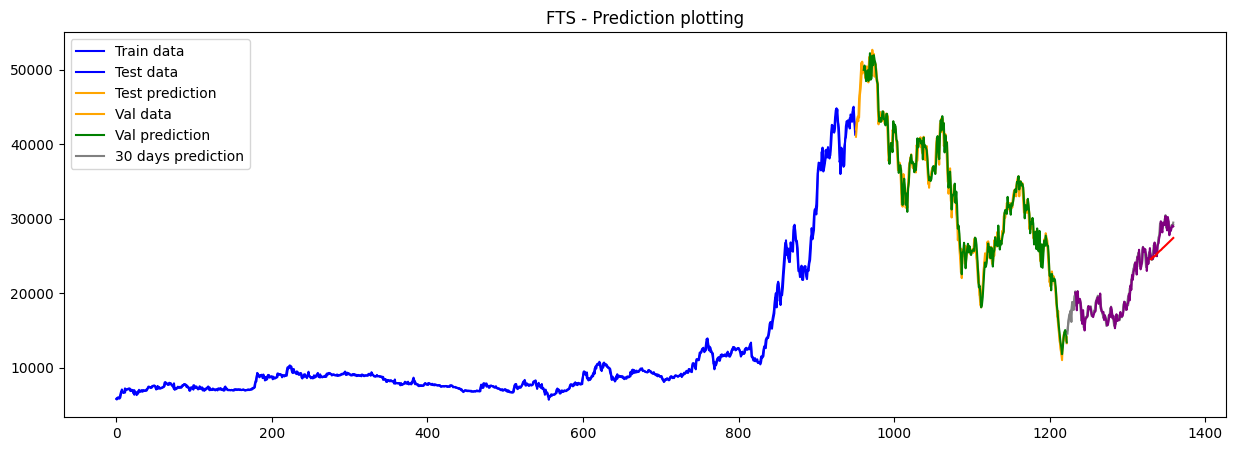

In [ ]:
plt.figure(figsize=(15,5))

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data), c='b')

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data), 'orange')

test_data_index = pd.RangeIndex(start=train_size + lags + 1, stop=train_size+test_size, step=1)
plt.plot(test_data_index, (y_pred_test), 'green')

val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index, scaler.inverse_transform(val_data), 'gray')

val_data_index = pd.RangeIndex(start=train_size+test_size + lags + 1, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index, y_pred_val, 'purple')

prediect_data_index = pd.RangeIndex(start=len(df_price)-number_of_days_to_predict, stop=len(df_price), step=1)
plt.plot(prediect_data_index, ndays_pred, 'red')

plt.legend(['Train data', 'Test data', 'Test prediction', 'Val data', 'Val prediction', '{0} days prediction'.format(number_of_days_to_predict)], loc='upper left')
plt.title('FTS - Prediction plotting')
plt.show()

### Dataset 2: MWG

In [ ]:
df_mwg['Date'] = pd.to_datetime(df_mwg['Date'])
df_mwg = df_mwg.sort_values(by='Date', ascending=True)
df_mwg.head(5)

,Date,Price,Open,High,Low,Vol.,Change %
1359,2018-01-02,31276,31039,31394,31039,2.27M,0.76%
1358,2018-01-03,31892,31323,32034,31276,4.53M,1.97%
1357,2018-01-04,31963,31773,32081,31750,2.71M,0.22%
1356,2018-01-05,31608,31987,31987,31465,2.93M,-1.11%
1355,2018-01-08,31110,31394,31513,31039,3.01M,-1.58%


- Split Price data
- Reset index

In [ ]:
df_price = df_mwg[['Price', 'Open']]
df_price = df_price.reset_index(drop=True)
df_price.head(5)

,Price,Open
0,31276,31039
1,31892,31323
2,31963,31773
3,31608,31987
4,31110,31394


- Scale data between 0 and 1:

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
df_price['Price'] = scaler.fit_transform(np.array(df_price['Price']).reshape(-1,1))
df_price['Open'] = scaler.transform(np.array(df_price['Open']).reshape(-1,1))
df_price.head(5)

,Price,Open
0,0.200020,0.196095
1,0.210221,0.200798
2,0.211397,0.208251
3,0.205518,0.211795
4,0.197271,0.201974


- Split data into train, test, val (7 - 2 - 1):

In [ ]:
train_size = int(0.7 * len(df_price))
test_size = int(0.2 * len(df_price))
val_size = len(df_price) - train_size - test_size

train_data = df_price[:train_size]
test_data = df_price[train_size:train_size+test_size]
val_data = df_price[train_size+test_size:]

print(train_data.shape)
print(test_data.shape)
print(val_data.shape)

(951, 2)
(272, 2)
(137, 2)


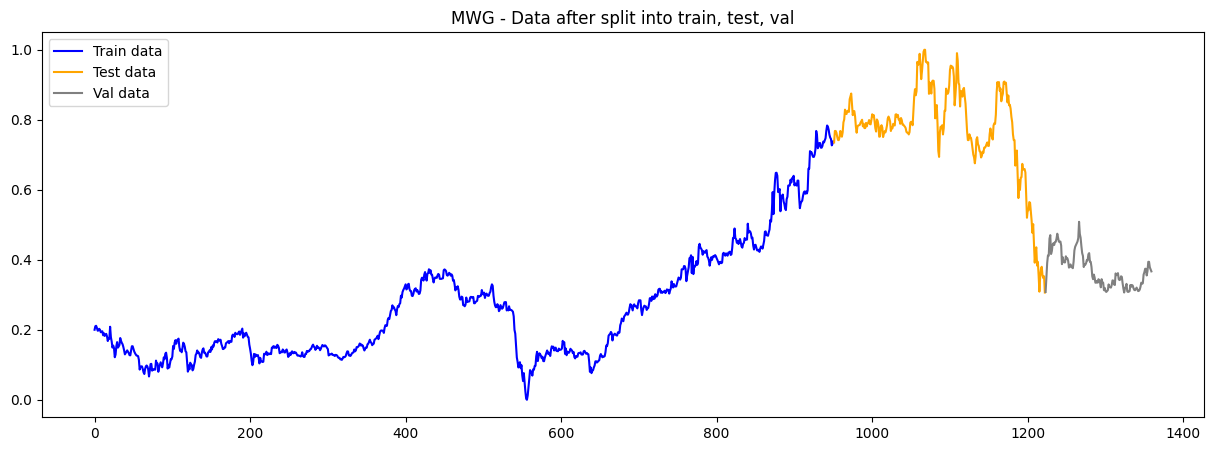

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(train_data.index, train_data['Price'], 'b')
plt.plot(test_data.index, test_data['Price'], 'orange')
plt.plot(val_data.index, val_data['Price'], 'gray')
plt.legend(['Train data', 'Test data', 'Val data'], loc='upper left')
plt.title('MWG - Data after split into train, test, val')
plt.show()

- Model training:

In [ ]:
model_var = VAR(train_data)
for i in [1,2,3,4,5,6,7,8,9,10]:
    results = model_var.fit(i)
    print('Order =', i)
    print('AIC: ', results.aic)
    print('BIC: ', results.bic)
    print()

Order = 1
AIC:  -19.39866064117361
BIC:  -19.367988249691958

Order = 2
AIC:  -19.426796543808905
BIC:  -19.3756331212735

Order = 3
AIC:  -19.44655282689949
BIC:  -19.374864047330327

Order = 4
AIC:  -19.44513082168115
BIC:  -19.3528822644717

Order = 5
AIC:  -19.4412001161344
BIC:  -19.328357265691334

Order = 6
AIC:  -19.434006113410607
BIC:  -19.30053435879173

Order = 7
AIC:  -19.424293696645012
BIC:  -19.270158331195475

Order = 8
AIC:  -19.414948250938114
BIC:  -19.240114471924816

Order = 9
AIC:  -19.419647996217837
BIC:  -19.224080904462102

Order = 10
AIC:  -19.41936598488684
BIC:  -19.203030584395254



In [ ]:
result = model_var.fit(3)
result.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 17, Jun, 2023
Time:                     11:06:39
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -19.3749
Nobs:                     948.000    HQIC:                  -19.4192
Log likelihood:           6541.36    FPE:                3.58484e-09
AIC:                     -19.4466    Det(Omega_mle):     3.53248e-09
--------------------------------------------------------------------
Results for equation Price
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const           -0.000060         0.000744           -0.080           0.936
L1.Price         0.963571         0.037090           25.979           0.000
L1.Open         -0.002349         0.079770           -0.029           0.977
L2.P

- Model Prediction on test, val (one-step prediction):

In [ ]:
lags_order = result.k_ar

In [ ]:
y_pred_test = []
for i in range(test_data.shape[0] - lags_order):
    forecast_input = test_data[i:(i+lags_order)].values
    pred = result.forecast(forecast_input, steps=1)
    y_pred_test.append(list(pred[0]))

y_pred_test = np.array(y_pred_test)[:, 0]

In [ ]:
y_pred_val = []
for i in range(val_data.shape[0] - lags_order):
    forecast_input = val_data[i:(i+lags_order)].values
    pred = result.forecast(forecast_input, steps=1)
    y_pred_val.append(list(pred[0]))

y_pred_val = np.array(y_pred_val)[:, 0]

In [ ]:
y_pred_test = scaler.inverse_transform(y_pred_test.reshape(-1, 1))
y_pred_val = scaler.inverse_transform(y_pred_val.reshape(-1, 1))

- 30 days prediction:

In [ ]:
number_of_days_to_predict = 30

In [ ]:
ndays_pred = result.forecast(df_price[-lags_order-number_of_days_to_predict:-number_of_days_to_predict].values, steps=number_of_days_to_predict)
ndays_pred = np.array(ndays_pred)[:, 0]
ndays_pred = scaler.inverse_transform(np.array(ndays_pred).reshape(-1, 1))

- Model evaluating (RMSE - MAPE - MSLE):

In [ ]:
y_test = test_data['Price'].values[lags_order:]
y_val = val_data['Price'].values[lags_order:]
last_ndays_data = val_data['Price'].values[-number_of_days_to_predict:]

In [ ]:
last_ndays_data = df_price[-number_of_days_to_predict:]['Price'].values

# RMSE
test_rmse = mean_squared_error(y_pred_test, y_test, squared=False)
val_rmse = mean_squared_error(y_pred_val, y_val, squared=False)
ndays_rmse = mean_squared_error(ndays_pred, last_ndays_data, squared=False)
print('Testing RMSE:', np.round(test_rmse, 4))
print('Validating RMSE:', np.round(val_rmse, 4))
print('Predicting {0} days RMSE:'.format(number_of_days_to_predict), np.round(ndays_rmse, 4))

# MAPE
test_mape = mean_absolute_percentage_error(y_pred_test, y_test)
val_mape = mean_absolute_percentage_error(y_pred_val, y_val)
ndays_mape = mean_absolute_percentage_error(ndays_pred, last_ndays_data)
print('\nTesting MAPE:', np.round(test_mape, 4))
print('Validating MAPE:', np.round(val_mape, 4))
print('Predicting {0} days MAPE:'.format(number_of_days_to_predict), np.round(ndays_mape, 4))

# MSLE
test_msle = mean_squared_log_error(y_pred_test, y_test)
val_msle = mean_squared_log_error(y_pred_val, y_val)
ndays_msle = mean_squared_log_error(ndays_pred, last_ndays_data)
print('\nTesting MSLE:', np.round(test_msle, 4))
print('Validating MSLE:', np.round(val_msle, 4))
print('Predicting {0} days MSLE:'.format(number_of_days_to_predict), np.round(ndays_msle, 4))


Testing RMSE: 66571.6766
Validating RMSE: 41840.6197
Predicting 30 days RMSE: 38078.8176

Testing MAPE: 1.0
Validating MAPE: 1.0
Predicting 30 days MAPE: 1.0

Testing MSLE: 110.6936
Validating MSLE: 106.5244
Predicting 30 days MSLE: 105.1728


- Prediction plotting:

In [ ]:
lags = lags_order - 1

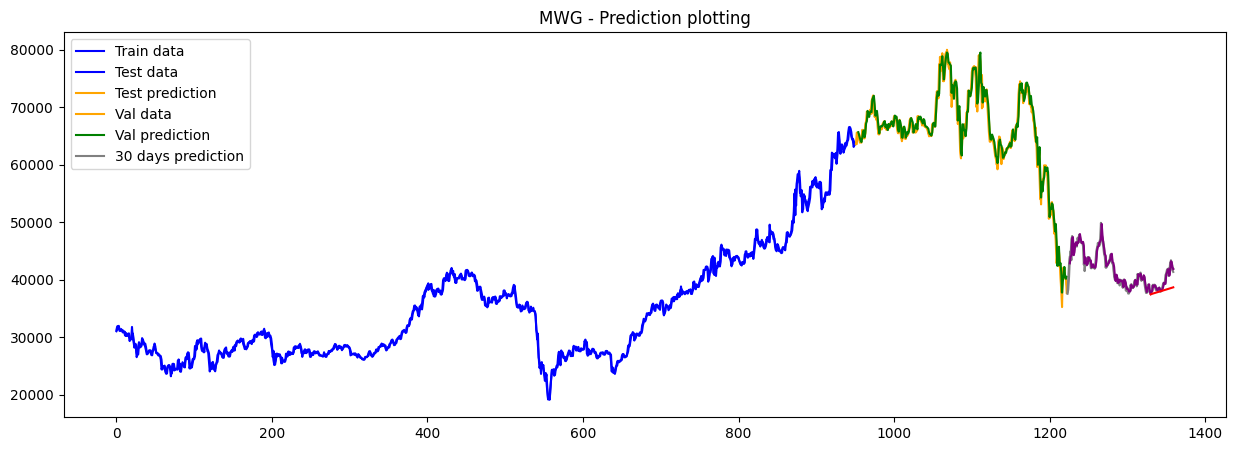

In [ ]:
plt.figure(figsize=(15,5))

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data), c='b')

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data), 'orange')

test_data_index = pd.RangeIndex(start=train_size + lags + 1, stop=train_size+test_size, step=1)
plt.plot(test_data_index, (y_pred_test), 'green')

val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index, scaler.inverse_transform(val_data), 'gray')

val_data_index = pd.RangeIndex(start=train_size+test_size + lags + 1, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index, y_pred_val, 'purple')

prediect_data_index = pd.RangeIndex(start=len(df_price)-number_of_days_to_predict, stop=len(df_price), step=1)
plt.plot(prediect_data_index, ndays_pred, 'red')

plt.legend(['Train data', 'Test data', 'Test prediction', 'Val data', 'Val prediction', '{0} days prediction'.format(number_of_days_to_predict)], loc='upper left')
plt.title('MWG - Prediction plotting')
plt.show()

- Prediction plotting:

### Dataset 3: VIC

In [ ]:
df_vic['Date'] = pd.to_datetime(df_vic['Date'])
df_vic = df_vic.sort_values(by='Date', ascending=True)
df_vic.head(5)

,Date,Price,Open,High,Low,Vol.,Change %
1359,2018-01-02,64628,64132,64876,63967,1.74M,1.16%
1358,2018-01-03,66529,65702,68760,64959,6.07M,2.94%
1357,2018-01-04,66942,67355,68678,66529,3.55M,0.62%
1356,2018-01-05,66116,66942,66942,65289,3.42M,-1.23%
1355,2018-01-08,66364,66116,67686,65372,4.81M,0.38%


- Split Price data
- Reset index

In [ ]:
df_price = df_vic[['Price', 'Open']]
df_price = df_price.reset_index(drop=True)
df_price.head(5)

,Price,Open
0,64628,64132
1,66529,65702
2,66942,67355
3,66116,66942
4,66364,66116


- Scale data between 0 and 1:

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
df_price['Price'] = scaler.fit_transform(np.array(df_price['Price']).reshape(-1,1))
df_price['Open'] = scaler.transform(np.array(df_price['Open']).reshape(-1,1))
df_price.head(5)

,Price,Open
0,0.182297,0.175897
1,0.206826,0.196155
2,0.212155,0.217484
3,0.201497,0.212155
4,0.204697,0.201497


- Split data into train, test, val (7 - 2 - 1):

In [ ]:
train_size = int(0.7 * len(df_price))
test_size = int(0.2 * len(df_price))
val_size = len(df_price) - train_size - test_size

train_data = df_price[:train_size]
test_data = df_price[train_size:train_size+test_size]
val_data = df_price[train_size+test_size:]

print(train_data.shape)
print(test_data.shape)
print(val_data.shape)

(951, 2)
(272, 2)
(137, 2)


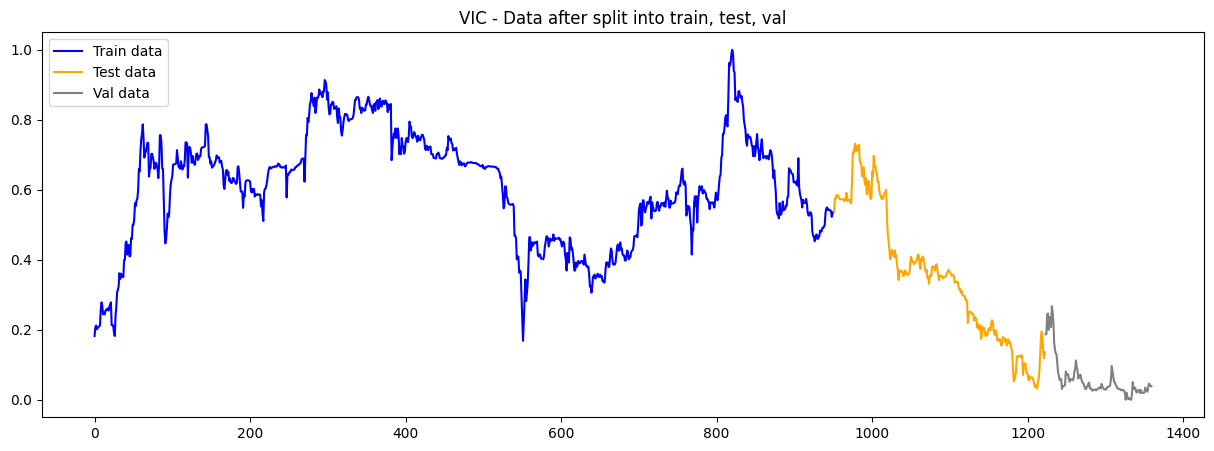

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(train_data.index, train_data['Price'], 'b')
plt.plot(test_data.index, test_data['Price'], 'orange')
plt.plot(val_data.index, val_data['Price'], 'gray')
plt.legend(['Train data', 'Test data', 'Val data'], loc='upper left')
plt.title('VIC - Data after split into train, test, val')
plt.show()

- Model training:

In [ ]:
model_var = VAR(train_data)
for i in [1,2,3,4,5,6,7,8,9,10]:
    results = model_var.fit(i)
    print('Order =', i)
    print('AIC: ', results.aic)
    print('BIC: ', results.bic)
    print()

Order = 1
AIC:  -16.262788218335455
BIC:  -16.232115826853803

Order = 2
AIC:  -16.28274112267718
BIC:  -16.231577700141774

Order = 3
AIC:  -16.275458913794274
BIC:  -16.20377013422511

Order = 4
AIC:  -16.29243346952585
BIC:  -16.2001849123164

Order = 5
AIC:  -16.2980002747957
BIC:  -16.185157424352635

Order = 6
AIC:  -16.295318615326455
BIC:  -16.161846860707577

Order = 7
AIC:  -16.286362085282416
BIC:  -16.13222671983288

Order = 8
AIC:  -16.282606006311457
BIC:  -16.10777222729816

Order = 9
AIC:  -16.28034408756478
BIC:  -16.084776995809047

Order = 10
AIC:  -16.273807769672768
BIC:  -16.05747236918118



In [ ]:
result = model_var.fit(5)
result.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 17, Jun, 2023
Time:                     11:09:18
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -16.1852
Nobs:                     946.000    HQIC:                  -16.2550
Log likelihood:           5046.32    FPE:                8.35352e-08
AIC:                     -16.2980    Det(Omega_mle):     8.16259e-08
--------------------------------------------------------------------
Results for equation Price
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const            0.008609         0.003104            2.773           0.006
L1.Price         1.012471         0.035908           28.196           0.000
L1.Open         -0.020258         0.062069           -0.326           0.744
L2.P

- Model Prediction on test, val (one-step prediction):

In [ ]:
lags_order = result.k_ar

In [ ]:
y_pred_test = []
for i in range(test_data.shape[0] - lags_order):
    forecast_input = test_data[i:(i+lags_order)].values
    pred = result.forecast(forecast_input, steps=1)
    y_pred_test.append(list(pred[0]))

y_pred_test = np.array(y_pred_test)[:, 0]

In [ ]:
y_pred_val = []
for i in range(val_data.shape[0] - lags_order):
    forecast_input = val_data[i:(i+lags_order)].values
    pred = result.forecast(forecast_input, steps=1)
    y_pred_val.append(list(pred[0]))

y_pred_val = np.array(y_pred_val)[:, 0]

In [ ]:
y_pred_test = scaler.inverse_transform(y_pred_test.reshape(-1, 1))
y_pred_val = scaler.inverse_transform(y_pred_val.reshape(-1, 1))

- 30 days prediction:

In [ ]:
number_of_days_to_predict = 30

In [ ]:
ndays_pred = result.forecast(df_price[-lags_order-number_of_days_to_predict:-number_of_days_to_predict].values, steps=number_of_days_to_predict)
ndays_pred = np.array(ndays_pred)[:, 0]
ndays_pred = scaler.inverse_transform(np.array(ndays_pred).reshape(-1, 1))

- Model evaluating (RMSE - MAPE - MSLE):

In [ ]:
y_test = test_data['Price'].values[lags_order:]
y_val = val_data['Price'].values[lags_order:]
last_ndays_data = val_data['Price'].values[-number_of_days_to_predict:]

In [ ]:
last_ndays_data = df_price[-number_of_days_to_predict:]['Price'].values

# RMSE
test_rmse = mean_squared_error(y_pred_test, y_test, squared=False)
val_rmse = mean_squared_error(y_pred_val, y_val, squared=False)
ndays_rmse = mean_squared_error(ndays_pred, last_ndays_data, squared=False)
print('Testing RMSE:', np.round(test_rmse, 4))
print('Validating RMSE:', np.round(val_rmse, 4))
print('Predicting {0} days RMSE:'.format(number_of_days_to_predict), np.round(ndays_rmse, 4))

# MAPE
test_mape = mean_absolute_percentage_error(y_pred_test, y_test)
val_mape = mean_absolute_percentage_error(y_pred_val, y_val)
ndays_mape = mean_absolute_percentage_error(ndays_pred, last_ndays_data)
print('\nTesting MAPE:', np.round(test_mape, 4))
print('Validating MAPE:', np.round(val_mape, 4))
print('Predicting {0} days MAPE:'.format(number_of_days_to_predict), np.round(ndays_mape, 4))

# MSLE
test_msle = mean_squared_log_error(y_pred_test, y_test)
val_msle = mean_squared_log_error(y_pred_val, y_val)
ndays_msle = mean_squared_log_error(ndays_pred, last_ndays_data)
print('\nTesting MSLE:', np.round(test_msle, 4))
print('Validating MSLE:', np.round(val_msle, 4))
print('Predicting {0} days MSLE:'.format(number_of_days_to_predict), np.round(ndays_msle, 4))


Testing RMSE: 79125.2286
Validating RMSE: 55407.9217
Predicting 30 days RMSE: 60439.7578

Testing MAPE: 1.0
Validating MAPE: 1.0
Predicting 30 days MAPE: 1.0

Testing MSLE: 120.0605
Validating MSLE: 118.1029
Predicting 30 days MSLE: 120.504


- Prediction plotting:

In [ ]:
lags = lags_order - 1

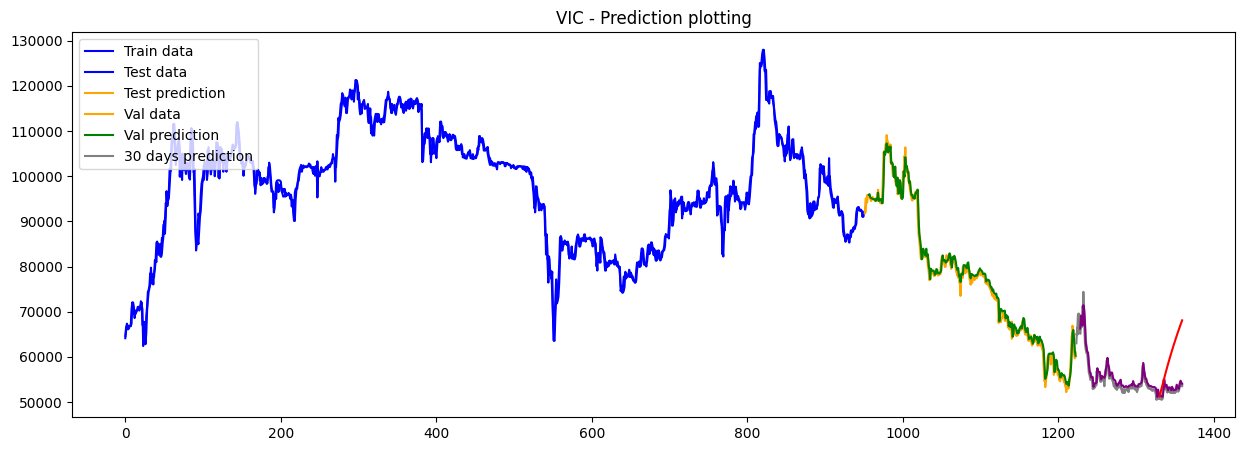

In [ ]:
plt.figure(figsize=(15,5))

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data), c='b')

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data), 'orange')

test_data_index = pd.RangeIndex(start=train_size + lags + 1, stop=train_size+test_size, step=1)
plt.plot(test_data_index, (y_pred_test), 'green')

val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index, scaler.inverse_transform(val_data), 'gray')

val_data_index = pd.RangeIndex(start=train_size+test_size + lags + 1, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index, y_pred_val, 'purple')

prediect_data_index = pd.RangeIndex(start=len(df_price)-number_of_days_to_predict, stop=len(df_price), step=1)
plt.plot(prediect_data_index, ndays_pred, 'red')

plt.legend(['Train data', 'Test data', 'Test prediction', 'Val data', 'Val prediction', '{0} days prediction'.format(number_of_days_to_predict)], loc='upper left')
plt.title('VIC - Prediction plotting')
plt.show()